# Data Science in Transportation
## Step-by-step tutorial with `python` `pandas` and NYC citi bikes data
(c) Rafal Kucharski Cracow University of Technology, Poland, rkucharski_at_pk.edu.pl

In this demo you will:
* download the online data
* parse it to `pandas DataFrame`


# Prerequisites
Before you start make sure you have installed:
* [python](https://www.python.org/downloads/) (tested for 3.6.3 version)
* python IDE (personally I reccommend [pyCharm](https://www.jetbrains.com/pycharm/))
* pip integrated with shell, so that `pip install pandas` will work

Imports

In [131]:
import os  # operating system calls
import pandas as pd  # coolest data sceince python module - extremely flexible and efficient
import zipfile  # unzips zipped zips
import matplotlib.pyplot as plt  # plots old school style, if you do not want plot.ly or sth similar
import numpy as np  # math operations
from shapely.geometry import Point  # shapefile like add-on for pandas
import plotly.plotly as py  # plot.ly python wrapper
from plotly.graph_objs import Data, Scattermapbox, Marker, Layout, Box  # plotly objects
import requests  # to scrap the data from the web
import scipy.stats as st  # statistical 
import seaborn as sns  # statistical fancy tools
import warnings  # python runtime warnings
from sklearn.metrics.pairwise import pairwise_distances  # the classical mighty machine learning module

Constants

In [246]:

topsize = 30
PLOTLY_API_KEY = "w1LROCX3bYA8amfuLA4g"

warnings.filterwarnings('ignore')
LOW_WARN = 3
HIGH_WARN = 3

PLOT_STYLES = dict(
    OK={'color': 'green', 'lw': 1, 'linestyle': '-'},
    FULL={'color': 'red', 'lw': 2, 'linestyle': ':'},
    EMPTY={'color': 'black', 'lw': 2, 'linestyle': ':'},
    LOW={'color': 'yellow', 'lw': 1, 'linestyle': '--'},
    HIGH={'color': 'yellow', 'lw': 1, 'linestyle': '--'})


# Data source
We use freely available datasets provided by _citi bike_ available [here](https://www.citibikenyc.com/system-data)
in this tutorial we focus on the historical data sets provided in this [amazon bucket](https://s3.amazonaws.com/tripdata/index.html)
for stability I copied three selected months (summer 2017) data in the repo [folder](https://github.com/RafalKucharskiPK/DataScience_for_TransportationResearch/tree/master/data)



## Data import
Here we:
* walk through the `./data/` folder, 
* unzip all .zip archives to '.csv' (on the fly - no files are stored)
* parse all `.csv.` files to `pandas DataFrame`
* index the `DataFrame` by datatime index (useful for futher time related calculations)

In [133]:
trips = list()
plot_x = list()
plot_y = list()
for file in os.listdir("./data/"):
    if file.endswith(".zip"):
        zip_ref = zipfile.ZipFile(os.path.join("./data/", file), 'r')
        df = pd.read_csv(zip_ref.extract(zip_ref.filelist[0]))
        df["starttime"] = pd.to_datetime(df["starttime"], format="%Y/%m/%d %H:%M:%S")
        df.index = df["starttime"]
        del df["starttime"]
        trips.append(df)

        plot_x.append(file.split("-")[0])
        plot_y.append(trips[-1].shape[0])
        print("Reading {}MB file of {:,} trips recorded on {}"
              .format(int(os.path.getsize(os.path.join("./data/", file)) / 1024 / 1024.0), trips[-1].shape[0], file.split("-")[0]))

trips = pd.concat(trips)

# delete unused data
del trips['stoptime']
del trips['start station name']
del trips['end station name']

Reading 60MB file of 1,816,498 trips recorded on 201708


Reading 57MB file of 1,735,599 trips recorded on 201707


Reading 57MB file of 1,731,594 trips recorded on 201706


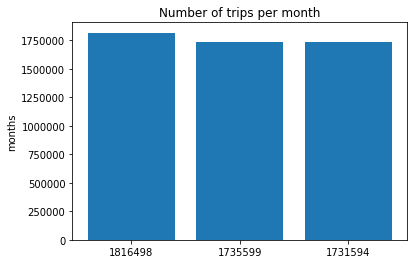

In [194]:
plt.bar([i for i, x in enumerate(plot_x)], plot_y)
plt.xticks([i for i, x in enumerate(plot_x)], plot_y)
plt.ylabel('number of bike rents')
plt.ylabel('months')
plt.title("Number of trips per month")
plt.show()

## Inspect, analyze, view the data

In [135]:
trips.columns # columns of the DataFrame


Index(['tripduration', 'start station id', 'start station latitude',
       'start station longitude', 'end station id', 'end station latitude',
       'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender'],
      dtype='object')

In [136]:
print("Mean trip duration is: ", trips.tripduration.mean())

Mean trip duration is:  1097.52567646


In [137]:
print("Mean trip duration in July is : ", trips.tripduration[trips.index.month==7].mean())

Mean trip duration in July is :  1060.14335973


In [138]:
print(trips[trips['start station id']==470].shape[0], " trips started at station 470")

12418  trips started at station 470


In [139]:
print("Top 10 destinations from station 470")
trips[trips['start station id']==470].groupby('end station id').size().sort_values(ascending=False).head(10)

Top 10 destinations from station 470


end station id
3255    445
459     415
435     385
494     297
523     294
212     264
462     233
402     218
3258    182
382     176
dtype: int64

In [140]:
print(trips.head()) # brief inspection of first 10 rows of Data

                     tripduration  start station id  start station latitude  \
starttime                                                                     
2017-08-01 00:00:00          2110               470               40.743453   
2017-08-01 00:00:10           160               348               40.724910   
2017-08-01 00:00:17          1644              3165               40.775794   
2017-08-01 00:00:27           323               389               40.710446   
2017-08-01 00:00:41           109              3145               40.778627   

                     start station longitude  end station id  \
starttime                                                      
2017-08-01 00:00:00               -74.000040            3289   
2017-08-01 00:00:10               -74.001547             151   
2017-08-01 00:00:17               -73.976206            3320   
2017-08-01 00:00:27               -73.965251            3073   
2017-08-01 00:00:41               -73.957721            3147  

In [141]:
trips.describe()  # general statistical description of data in DataFrame columns

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,5.283691e+06,5.283691e+06,5.283691e+06,5.283691e+06,5.283691e+06,5.283691e+06,5.283691e+06,5.283691e+06,4.637947e+06,5.283691e+06
mean,1.097526e+03,1.352630e+03,4.073583e+01,-7.398516e+01,1.349570e+03,4.073554e+01,-7.398525e+01,2.324025e+04,1.979415e+03,1.105788e+00
std,1.500801e+04,1.342407e+03,3.808385e-02,4.869711e-02,1.341921e+03,4.554701e-02,6.666835e-02,5.012161e+03,1.158522e+01,5.887127e-01
min,6.100000e+01,7.200000e+01,0.000000e+00,-7.402535e+01,7.200000e+01,0.000000e+00,-7.406692e+01,1.452900e+04,1.874000e+03,0.000000e+00
25%,3.940000e+02,3.590000e+02,4.071755e+01,-7.399725e+01,3.590000e+02,4.071745e+01,-7.399726e+01,1.844300e+04,1.972000e+03,1.000000e+00
50%,6.690000e+02,4.850000e+02,4.073650e+01,-7.398766e+01,4.840000e+02,4.073649e+01,-7.398783e+01,2.522800e+04,1.982000e+03,1.000000e+00
75%,1.167000e+03,3.140000e+03,4.075514e+01,-7.397606e+01,3.139000e+03,4.075510e+01,-7.397621e+01,2.778800e+04,1.988000e+03,1.000000e+00
max,4.509256e+06,3.489000e+03,4.550636e+01,0.000000e+00,3.489000e+03,4.550636e+01,0.000000e+00,3.082700e+04,2.001000e+03,2.000000e+00


In [142]:
# filter rows
date_from = "2017-06-01"
date_to = "2017-06-02"
filtered_trips = trips.loc[date_from:date_to]  # filter trips to a given date rang
print("Between {} and {} there were {} trips".format(date_from,date_to,filtered_trips.shape[0]))

Between 2017-06-01 and 2017-06-02 there were 134310 trips


## Make stations

In [143]:

st = pd.DataFrame(np.union1d(trips['start station id'].unique(),
                             trips['end station id'].unique()),
                  columns=["station_id"])
locs = list()
sizes = list()
for index, row in st.iterrows():
    locs.append(
        [trips[trips['start station id'] == row["station_id"]]['start station longitude'].mean(),
         trips[trips['start station id'] == row["station_id"]]['start station latitude'].mean()]
    )
    sizes.append(trips[trips['start station id'] == row["station_id"]].shape[0])
st['pos'] = [Point(loc[0], loc[1]) for loc in locs]
st['lon'] = [loc[0] for loc in locs]
st['lat'] = [loc[1] for loc in locs]
st['orig_trips'] = sizes
stations = st.set_index("station_id")

## Get Real-time data

In [206]:
json = requests.get("https://gbfs.citibikenyc.com/gbfs/en/station_status.json").json()
data = json['data']['stations']
station_status = pd.DataFrame(data)
station_status = station_status.set_index("station_id")

In [207]:
print("Count empty stations")
station_status[station_status.num_bikes_available == 0].shape[0]

Count empty stations


34

In [208]:
print("10 full stations")
station_status[station_status.num_docks_available==0].num_docks_available.nsmallest(10)

10 full stations


station_id
311     0
345     0
385     0
449     0
456     0
539     0
3093    0
3177    0
3324    0
3333    0
Name: num_docks_available, dtype: int64

## OD matrix

In [148]:
matrix = trips.groupby(by=['start station id', 'end station id'])
OD = matrix.size()  # make trip matrix
OD = OD.unstack().fillna(0)

In [149]:
OD.head()

end station id,72,79,82,83,116,119,120,127,128,143,...,3472,3474,3476,3477,3478,3479,3481,3485,3488,3489
start station id,,,,,,,,,,,,,,,,,,,,,
72,330.0,12.0,2.0,0.0,17.0,0.0,0.0,69.0,17.0,2.0,...,52.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,32.0,122.0,4.0,3.0,12.0,0.0,1.0,90.0,69.0,0.0,...,13.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,3.0,137.0,0.0,1.0,4.0,0.0,1.0,34.0,0.0,...,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,1.0,0.0,85.0,0.0,1.0,48.0,2.0,0.0,19.0,...,0.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0
116,40.0,22.0,6.0,0.0,178.0,0.0,1.0,155.0,54.0,0.0,...,35.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
relative_OD = matrix.size().groupby(level=0).apply(lambda x: x / float(x.sum()))
relative_OD = relative_OD.unstack().fillna(0)
relative_OD.head()

end station id,72,79,82,83,116,119,120,127,128,143,...,3472,3474,3476,3477,3478,3479,3481,3485,3488,3489
start station id,,,,,,,,,,,,,,,,,,,,,
72,0.026213,0.000953,0.000159,0.000000,0.001350,0.000000,0.000000,0.005481,0.001350,0.000159,...,0.004131,0.000874,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
79,0.003548,0.013528,0.000444,0.000333,0.001331,0.000000,0.000111,0.009980,0.007651,0.000000,...,0.001442,0.003105,0.000111,0.000111,0.000000,0.0,0.0,0.0,0.0,0.0
82,0.000000,0.000738,0.033711,0.000000,0.000246,0.000984,0.000000,0.000246,0.008366,0.000000,...,0.000984,0.000738,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
83,0.000000,0.000205,0.000000,0.017414,0.000000,0.000205,0.009834,0.000410,0.000000,0.003893,...,0.000000,0.000205,0.000000,0.000205,0.001024,0.0,0.0,0.0,0.0,0.0
116,0.003093,0.001701,0.000464,0.000000,0.013762,0.000000,0.000077,0.011984,0.004175,0.000000,...,0.002706,0.000696,0.000077,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


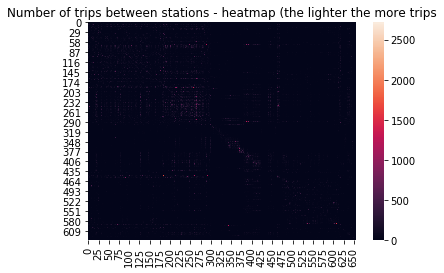

In [193]:
cmap = sns.color_palette("cubehelix", 16)
df_mtx = OD.as_matrix()
sns.heatmap(df_mtx)
plt.title("Number of trips between stations - heatmap (the lighter the more trips")
plt.show()

## Travel time distribution

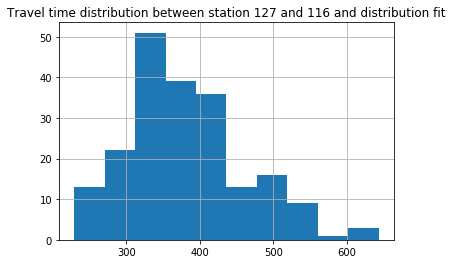

In [191]:
matrix = trips.groupby(by=['start station id', 'end station id'])  # pivot the trips for the matrix
durations = matrix.get_group((127, 116)).tripduration  # access a single cell of the matrix
durations = durations[durations < durations.quantile(0.95)]  # filter below the given percentile
durations.hist()
plt.title("Travel time distribution between station 127 and 116 and distribution fit")
plt.show()

### Distribution fit

norm:	0.0000222	 loc: 	380.808	 scale: 	380.808
lognorm:	0.0002678	 loc: 	229.000	 scale: 	229.000
gamma:	0.0000143	 loc: 	155.655	 scale: 	155.655
rayleigh:	0.0000174	 loc: 	221.942	 scale: 	221.942
best distribution: 	 gamma


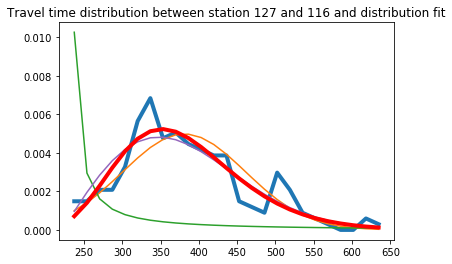

In [195]:
import scipy.stats as st
data = durations.as_matrix()
y, x = np.histogram(data, bins=25, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

distributions = [st.norm, st.lognorm, st.gamma, st.rayleigh]

best_sse = np.inf

plt.plot(x, y, lw=4)
for distribution in distributions:

    params = distribution.fit(data)

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(y - pdf, 2.0))
    print(distribution.name + ":\t" + '%.7f' % sse + "\t loc: \t" + '%.3f' % loc + "\t scale: \t" + '%.3f' % loc)
    plt.plot(x, pdf)

    if best_sse > sse > 0:
        best_distribution = distribution
        best_params = params
        best_sse = sse

print("best distribution: \t " + best_distribution.name)
best_pdf = best_distribution.pdf(x, loc=best_params[-2], scale=best_params[-1], *best_params[:-2])
plt.plot(x, best_pdf, lw=4, color='red')
plt.title("Travel time distribution between station 127 and 116 and distribution fit")
plt.show()

## Describe single day

In [178]:
by1 = [trips.index.date, trips.index.hour]
by2 = [trips.index.date]
hours = trips['bikeid'].groupby(by=by1).count()  # total trips per day,  hour
hours = hours.reset_index()  # flatten the multi index pandas data frame
hours.columns = ["date", "hour", "trips"]  # make understandable index names
days = hours.pivot(index="date", columns='hour', values='trips')  # use hours as columns (fields)
days['totals'] = trips['bikeid'].groupby(by=by2).count()  # add totals
days.index = pd.to_datetime(days.index)
days["weekday"] = days.index.dayofweek

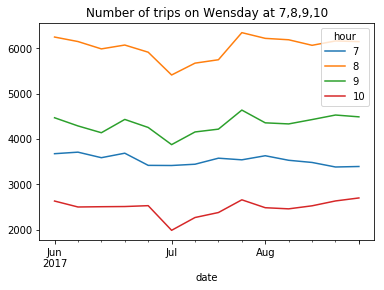

In [196]:
days[days.weekday == 3][[7, 8, 9, 10]].plot()
plt.title("Number of trips on Wensday at 7,8,9,10")
plt.show()

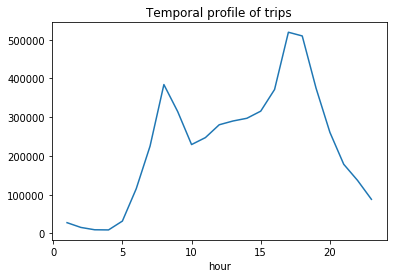

In [198]:
days[list(range(1, 24))].sum().plot()
plt.title("Temporal profile of trips")
plt.show()

## Station loads

In [241]:
agg = "5min"
date_from="2017-08-01"
_trips = trips.loc[date_from]
# this table is:
# time as index (row),
# start_station_id in columns,
# bikeid when bike is rented from station (col) at time(row),
# NaN otherwise
rentals = _trips.pivot_table(index=_trips.index, columns='start station id', values='bikeid')
# now we make it to boolean (1 for rentals, and 0 for all NaN's)
# we resample it for 5min (param) intervals and do the cumulative sum
rentals = rentals.notna().resample(agg).sum().cumsum().ffill()
# the same with dropsin
# we need the drop timestamp
_trips = _trips.drop(_trips[_trips.tripduration > 7200].index)
_trips = _trips.assign(drop_time=pd.Series(_trips.index + pd.to_timedelta(_trips.tripduration, unit='s')).values)

drops = _trips.pivot_table(index=_trips.drop_time, columns='end station id', values='bikeid')
drops = drops.notna().resample(agg).sum().cumsum().ffill().bfill()

multiindex = {"rentals": rentals, "drops": drops}  # make data for multilevel column index
balance = pd.concat(multiindex.values(), axis=1, keys=multiindex.keys())  # join two tables on columns (outer)
balance.rentals = balance.rentals.ffill()  # fill intervals with no rents/drops with 0
balance.drops = balance.drops.bfill()  # fill intervals with no rents/drops with 0
balance.columns = balance.columns.swaplevel()  # swap the levels of multilevel index (more useful)


## Balance

In [247]:
initial_loads = station_status.num_bikes_available
capacities = station_status.num_bikes_available+10
for station_id in set(balance.columns.get_level_values(0)):
    if ('rentals' in list(balance[station_id].columns)) and\
            ('drops' in list(balance[station_id].columns)):
        initial_load = initial_loads.loc[station_id] if station_id in initial_loads else 15
        capacity = capacities.loc[station_id] if station_id in capacities else 15
        # print("station: {}, capacity: {}, initial load: {}".format(station_id, capacity, initial_load))

        balance[station_id, "total"] = initial_load + balance[station_id].drops - balance[station_id].rentals
        alerts = list()
        for tot in balance[station_id, "total"]:
            if tot < 0:
                alerts.append("EMPTY")
            elif tot < LOW_WARN:
                alerts.append("LOW")
            elif tot >= capacity:
                alerts.append("FULL")
            elif tot >= capacity - HIGH_WARN:
                alerts.append("HIGH")
            else:
                alerts.append("OK")
        balance[station_id, "alerts"] = alerts

## Plot station status

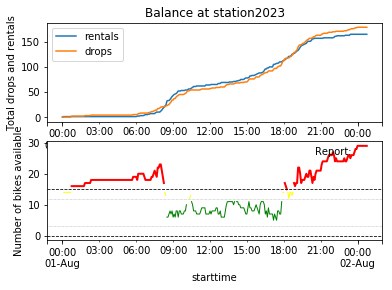

In [253]:
station = balance[72]
fig, axes = plt.subplots(nrows=2, ncols=1)
station[['rentals', 'drops']].plot(ax=axes[0])

for i in station.alerts.unique():
    df = station.where(station.alerts == i).total
    df.plot(ax=axes[1], color=PLOT_STYLES[i]['color'], lw=PLOT_STYLES[i]['lw'])

axes[1].axhline(y=15,
                color='black', linestyle='--', lw=0.8)
axes[1].axhline(y=15-HIGH_WARN,
                color='gray', linestyle=':', lw=0.5)
axes[1].axhline(y=LOW_WARN,
                color='gray', linestyle=':', lw=0.5)
axes[1].axhline(y=0,
                color='black', linestyle='--', lw=0.8)

axes[0].set_ylabel("Total drops and rentals")
axes[1].set_ylabel("Number of bikes available")
axes[0].set_title('Balance at station' + str(station_id))


plt.text(0.8, 0.9, "Report:", horizontalalignment='left', verticalalignment='center', transform=axes[1].transAxes)
#plt.text(0.8, 0.8, "lost drops: "+str(int(report['lost_drops'])), horizontalalignment='left',
#         verticalalignment='center', transform=axes[1].transAxes)
#plt.text(0.8, 0.7, "lost rentals: " + str(int(report['lost_rents'])), horizontalalignment='left',
#         verticalalignment='center',
#         transform=axes[1].transAxes)

plt.show()
